In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import numpy as np
import os
#from heatmap import heatmap, corrplot
import plotly.express as px
plt.style.use('ggplot')

In [2]:
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
from math import ceil
from scipy.spatial import distance

# Best Year-Month-Day of all stations
 * 2016-2017, 2016 -> May-Sep, Nov-Dec, 2017 -> Ene-Feb, Jun-Aug
 * 2016 -> May -> 17,18,31, Jun -> 3-12,21-30, Jul -> 1-9,11-13,15,16,20-31, Aug -> 2-24, Sep -> 2-4,23, Nov -> 11,12,22,23,25-30, Dec -> 3-5,12-28,30,31
 * 2017 -> Ene -> 1-4,6-10,12,13,23-27,29,30, Feb -> 24-28, Jun -> 6,9-11,16-25,30, Jul -> 1-4, Aug -> 11-14,19-22

In [3]:
# Distance between stations
def haversine(lat1, lon1, lat2, lon2):
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    return R *2.0 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def distance_stations(location):
    uniq = location.id_station_id.unique()
    n = len(uniq)
    d = pd.DataFrame(np.zeros((n,n)),uniq,uniq)
    for i in range(n):
        for j in range(i+1):
            lat1,lon1 = [np.float64(location[location.id_station_id==uniq[i]]["lat"])[0],np.float64(location[location.id_station_id==uniq[i]]["lon"])[0]]
            lat2,lon2 = [np.float64(location[location.id_station_id==uniq[j]]["lat"])[0],np.float64(location[location.id_station_id==uniq[j]]["lon"])[0]]
            d.iloc[i,j] = haversine(lat1, lon1, lat2, lon2)
    return d



def simple_krige(df,xcol,ycol,vcol,dfl,xlcol,ylcol,vario,skmean):
# load the variogram
    nst = vario['nst']; pmx = 9999.9
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    nug = vario['nug']; sill = nug 
    cc[0] = vario['cc1']; sill = sill + cc[0]
    it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:
        cc[1] = vario['cc2']; sill = sill + cc[1]
        it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];    

# set up the required matrices
    rotmat, maxcov = geostats.setup_rotmat(nug,nst,it,cc,ang,pmx)    
    ndata = len(df); a = np.zeros([ndata,ndata]); r = np.zeros(ndata); s = np.zeros(ndata); rr = np.zeros(ndata)
    nest = len(dfl)

    est = np.zeros(nest); var = np.full(nest,sill); weights = np.zeros([nest,ndata])

# Make and solve the kriging matrix, calculate the kriging estimate and variance 
    for iest in range(0,nest):
        for idata in range(0,ndata):
            for jdata in range(0,ndata):
                a[idata,jdata] = geostats.cova2(df[xcol].values[idata],df[ycol].values[idata],df[xcol].values[jdata],df[ycol].values[jdata],
                                        nst,nug,pmx,cc,aa,it,ang,anis,rotmat,maxcov)
            r[idata] = geostats.cova2(df[xcol].values[idata],df[ycol].values[idata],dfl[xlcol].values[iest],dfl[ylcol].values[iest],
                                        nst,nug,pmx,cc,aa,it,ang,anis,rotmat,maxcov)
            rr[idata] = r[idata]
        
        s = geostats.ksol_numpy(ndata,a,r)    
        sumw = 0.0
        for idata in range(0,ndata):                          
            sumw = sumw + s[idata]
            weights[iest,idata] = s[idata]
            est[iest] = est[iest] + s[idata]*df[vcol].values[idata]
            var[iest] = var[iest] - s[idata]*rr[idata]
        est[iest] = est[iest] + (1.0-sumw)*skmean
    return est,var,weights 

# function to take parameters, make sample and plot
def f_make_krige(nug,it1,azi,hmaj1,hmin1,x,y,value,xu,yu,): 
    it1 = convert_type(it1)
    nst = 1; xlag = 10; nlag = int(hmaj1/xlag); c1 = 1.0-nug
    vario = GSLIB.make_variogram(nug,nst,it1,c1,azi,hmaj1,hmin1) # make model object
    index_maj,h_maj,gam_maj,cov_maj,ro_maj = geostats.vmodel(nlag,xlag,azi,vario)   # project the model in the major azimuth                                                  # project the model in the 135 azimuth
    index_min,h_min,gam_min,cov_min,ro_min = geostats.vmodel(nlag,xlag,azi+90.0,vario) # project the model in the minor azimuth
    
    clist = ['blue','red','green']
    
    df = pd.DataFrame({'X':x,'Y':y,'Value':value})

    xl = [xu,0,1]; yl = [yu,0,1]; value1 = [0,0,0]
    dfl = pd.DataFrame({'X':xl,'Y':yl, 'Value':value1})
     
    sk_est, sk_var, sk_weights =  simple_krige(df,'X','Y','Value',dfl,'X','Y',vario,skmean=vmean)
    if sk_var[0] == 0:                                       # sk_std is used for plotting only, leave with sill = 1.0
        sk_std = 0.0
    else:
        sk_std = np.sqrt(sk_var[0])
    sk_var[0] = sk_var[0]*sill    
    xlag = 10.0; nlag = int(hmaj1/xlag)
    
    #plt.subplot(1,3,1)
    plt.plot([0,hmaj1*1.5],[1.0,1.0],color = 'black')
    plt.plot(h_maj,gam_maj,color = 'black',label = 'Major ' + str(azi))    
    plt.plot(h_min,gam_min,color = 'black',label = 'Minor ' + str(azi+90.0))
    deltas = [22.5, 45, 67.5]; 
    ndelta = len(deltas); hd = np.zeros(ndelta); gamd = np.zeros(ndelta);
    color=iter(cm.plasma(np.linspace(0,1,ndelta)))
    for delta in deltas:
        index,hd,gamd,cov,ro = geostats.vmodel(nlag,xlag,azi+delta,vario);
        c=next(color)
        plt.plot(hd,gamd,color = c,label = 'Azimuth ' + str(azi+delta))
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Interpolated NSCORE Porosity Variogram Models')
    plt.xlim([0,hmaj1*1.5])
    plt.ylim([0,1.4])
    plt.legend(loc='upper left')
    plt.show()
    """
    plt.subplot(1,3,2)
    if sk_weights[0,0] > 0.01:
        plt.scatter(x1,y1,color = 'blue', edgecolors = 'black', s = sk_weights[0,0]*1000, alpha = 0.3)
    else:
        plt.scatter(x1,y1,color = 'blue', edgecolors = 'black', marker = 'x', alpha = 0.3)
    if sk_weights[0,1] > 0.01:    
        plt.scatter(x2,y2,color = 'red', edgecolors = 'black', s = sk_weights[0,1]*1000,alpha = 0.3)
    else:
        plt.scatter(x2,y2,color = 'red', edgecolors = 'black', marker = 'x',alpha = 0.3)
    if sk_weights[0,2] > 0.01:
        plt.scatter(x3,y3,color = 'green', edgecolors = 'black', s = sk_weights[0,2]*1000, alpha = 0.3)
    else:
        plt.scatter(x3,y3,color = 'green', edgecolors = 'black', marker = 'x', alpha = 0.3)
       
    if (1-sk_std) > 0.01:
        scatter = plt.scatter(xu,yu,color = 'gray', edgecolors = 'black', s = (1-sk_std)*1000,alpha = 0.3)
    else: 
        scatter = plt.scatter(xu,yu,color = 'blue', edgecolors = 'black', marker = 'x', alpha = 0.3)
        
    ax = plt.gca()
    plt.xlabel('X(m)'); plt.ylabel('Y(m)')
    plt.title('Simple Kriging - Data and Unknown Locations')
    plt.xlim([0,1000])
    plt.ylim([0,1000])
    for i, txt in enumerate(np.round(sk_weights[0],2)):
        plt.annotate('$\lambda$' + ' ' + '$=$' + str(txt), (x[i]+20, y[i]+20),color = clist[i])
        plt.annotate(i+1, (x[i]+46, y[i]+15),fontsize=6,color = clist[i])
    for i, txt in enumerate(value):
        plt.annotate('$z($u' + ' ' + '$ )$  = ' + str(txt), (x[i]+20, y[i]-40),color = clist[i])
        plt.annotate(i+1, (x[i]+80, y[i]-45),fontsize=6,color = clist[i])
    plt.annotate('$\sum \lambda_{\\alpha} = $'+ str(np.round(np.sum(sk_weights[0]),2)), (xu+20, yu+20))
    plt.annotate('$z^*($u$)$ = '+ str(np.round(sk_est[0],2)), (xu+20, yu-40))
    plt.annotate('Mean Weight = ' + str(np.round(1.0 - np.sum(sk_weights[0]),2)), (20, 20))
    plt.annotate('?', (xu-20, yu + 30))

    ax = plt.gca()
    ellipse = Ellipse((xu, yu),width=hmin1*2.0,height=hmaj1*2.0,angle = 360-azi,facecolor='gray',alpha = 0.03)
    ax.add_patch(ellipse)
    ellipse = Ellipse((x1, y1),width=hmin1*2.0,height=hmaj1*2.0,angle = 360-azi,facecolor='blue',alpha = 0.03)
    ax.add_patch(ellipse)
    ellipse = Ellipse((x2, y2),width=hmin1*2.0,height=hmaj1*2.0,angle = 360-azi,facecolor='red',alpha = 0.03)
    ax.add_patch(ellipse)
    ellipse = Ellipse((x3, y3),width=hmin1*2.0,height=hmaj1*2.0,angle = 360-azi,facecolor='green',alpha = 0.03)
    ax.add_patch(ellipse)
    
    samples = norm.rvs(sk_est[0],math.sqrt(sk_var[0]),1000,random_state=73073)   
    plt.subplot(1,3,3)
    plt.hist(samples,histtype = 'stepfilled',cumulative = True, bins = np.linspace(vmin,vmax,200),alpha=0.2,color="red",edgecolor='black',density=True)
    plt.xlim([vmin,vmax]); plt.ylim([0,1.0])
    plt.title('Kriging Uncertainty Model at Unknown Location')
    plt.xlabel('Value'); plt.ylabel('Frequency')
    
    ax = plt.gca()
    ax.annotate('Simple Kriging Estimate = ' + str(np.round(sk_est[0],2)), (0.05*(vmax-vmin)+vmin, 0.9))
    ax.annotate('Simple Kriging Variance = ' + str(np.round(sk_var[0],2)), (0.05*(vmax-vmin)+vmin, 0.83))
    ax.annotate('Local P10 = ' + str(np.round(np.percentile(samples,10),2)), (0.05*(vmax-vmin)+vmin, 0.76))
    ax.annotate('Local P90 = ' + str(np.round(np.percentile(samples,90),2)), (0.05*(vmax-vmin)+vmin, 0.69))
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=0.9, wspace=0.3, hspace=0.3)
    """

Filtered data, best stations, between 6AM-10PM

In [ ]:
# Filter by pollutant on specific hour range
def poll(data,hour_range):
    return data[(data.UTC_hour_id>hour_range[0])&(data.UTC_hour_id<hour_range[1])]
location = pd.read_excel("Data/cat.xlsx",names=["id_station_id","lon","lat","alt","id"]).iloc[:,:3]
pollutants = pd.read_csv("Data/pollutantsAll.csv").iloc[:,[1,3,5,6,7]].merge(location,on="id_station_id",how="left")
st_19 = ["MER", "AJM", "PED", "SFE", "XAL", "HGM", "TLA", "FAC", "VIF", "MGH", "TAH", "MON", "CUA", "CUT", "UIZ", "NEZ", "UAX", "GAM", "SAG",
         "BJU", "MPA", "ACO", "SAC", "CCA", "INN", "CHO", "TLI", "LLA", "ATI", "CAM", "FAR"]

pollutants.dateUTCShiftedDown = pd.to_datetime(pollutants["dateUTCShiftedDown"])
pollutants = pollutants[(pollutants["id_station_id"].isin(st_19))&(pollutants.dateUTCShiftedDown.dt.year>2015)]
pollutants = poll(pollutants,[6.0,23.0])
pollutants.to_csv("Data/pollutants_filtered.csv",index=False,header=True)

In [4]:
pollutants = pd.read_csv("Data/pollutants_filtered.csv")
pollutants.dateUTCShiftedDown = pd.to_datetime(pollutants["dateUTCShiftedDown"])

In [5]:
location = pd.read_excel("Data/cat.xlsx",names=["id_station_id","lon","lat","alt","id"]).iloc[:,:3]
pm25 = pollutants[(pollutants.dateUTCShiftedDown.dt.day == 18)&(pollutants.dateUTCShiftedDown.dt.month == 5)&(pollutants.id_parameter_id == "PM2.5")].dropna() #.fillna(pm25['original'].mean())
#pm25 = pm25.groupby(by=["id_station_id",pd.Grouper(key="dateUTCShiftedDown",freq = "D")])["original"].mean().to_frame().reset_index().merge(location,on="id_station_id",how="left").dropna()
pm25.head()

,dateUTCShiftedDown,original,UTC_hour_id,id_parameter_id,id_station_id,lon,lat
516672,2020-05-18 06:00:00,25.0,7.0,PM2.5,UIZ,-99.073880,19.360794
516680,2020-05-18 06:00:00,21.0,7.0,PM2.5,UAX,-99.103629,19.304441
516719,2020-05-18 06:00:00,19.0,7.0,PM2.5,TLA,-99.204597,19.529077
516731,2020-05-18 06:00:00,22.0,7.0,PM2.5,BJU,-99.159596,19.370464
516737,2020-05-18 06:00:00,27.0,7.0,PM2.5,INN,-99.380520,19.291968


In [25]:
pm25['NOriginal'], tvPorPm25, tnsPorPm25 = geostats.nscore(pm25, 'original')
pm25.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
original,1087.0,31.580497,14.018296,1.000000,21.000000,29.000000,40.000000,85.000000
UTC_hour_id,1087.0,14.424103,4.604575,7.000000,10.000000,14.000000,18.000000,22.000000
lon,1087.0,-99.137299,0.089641,-99.380520,-99.202660,-99.152207,-99.073880,-98.902853
lat,1087.0,19.398004,0.089174,19.176900,19.326111,19.404050,19.468404,19.532968
lon2,1087.0,0.243221,0.089641,0.000000,0.177860,0.228313,0.306640,0.477667
lat2,1087.0,0.113022,0.245907,-0.115068,0.034143,0.112082,0.176436,7.661779
NOriginal,1087.0,0.039075,0.991317,-3.152777,-0.657936,0.002306,0.681018,3.313925


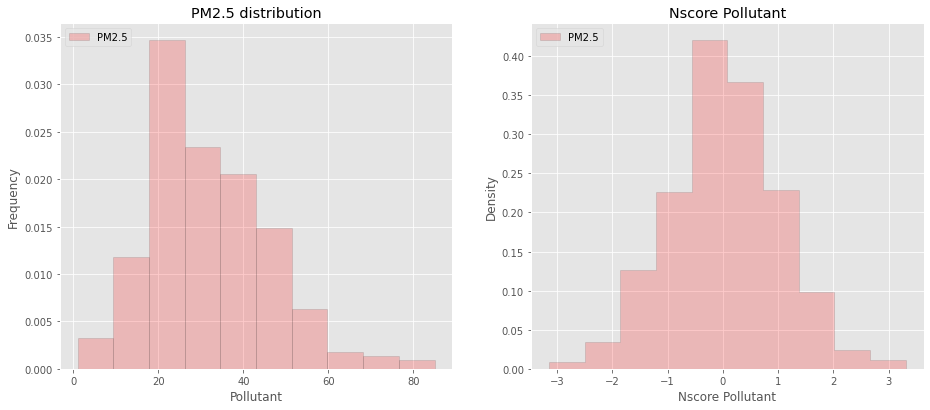

In [74]:
plt.subplot(121)                                        # plot original pm25 histograms
plt.hist(pm25['original'], facecolor='red',alpha=0.2,density=True,edgecolor='black',label='PM2.5')
plt.xlabel('Pollutant'); plt.ylabel('Frequency'); plt.title('PM2.5 distribution')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(122)                                        # plot nscore transformed pm25 histograms
plt.hist(pm25['NOriginal'], facecolor='red',histtype="stepfilled",alpha=0.2,density=True,cumulative=False,edgecolor='black',label='PM2.5')
plt.xlabel('Nscore Pollutant'); plt.ylabel('Density'); plt.title('Nscore Pollutant')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

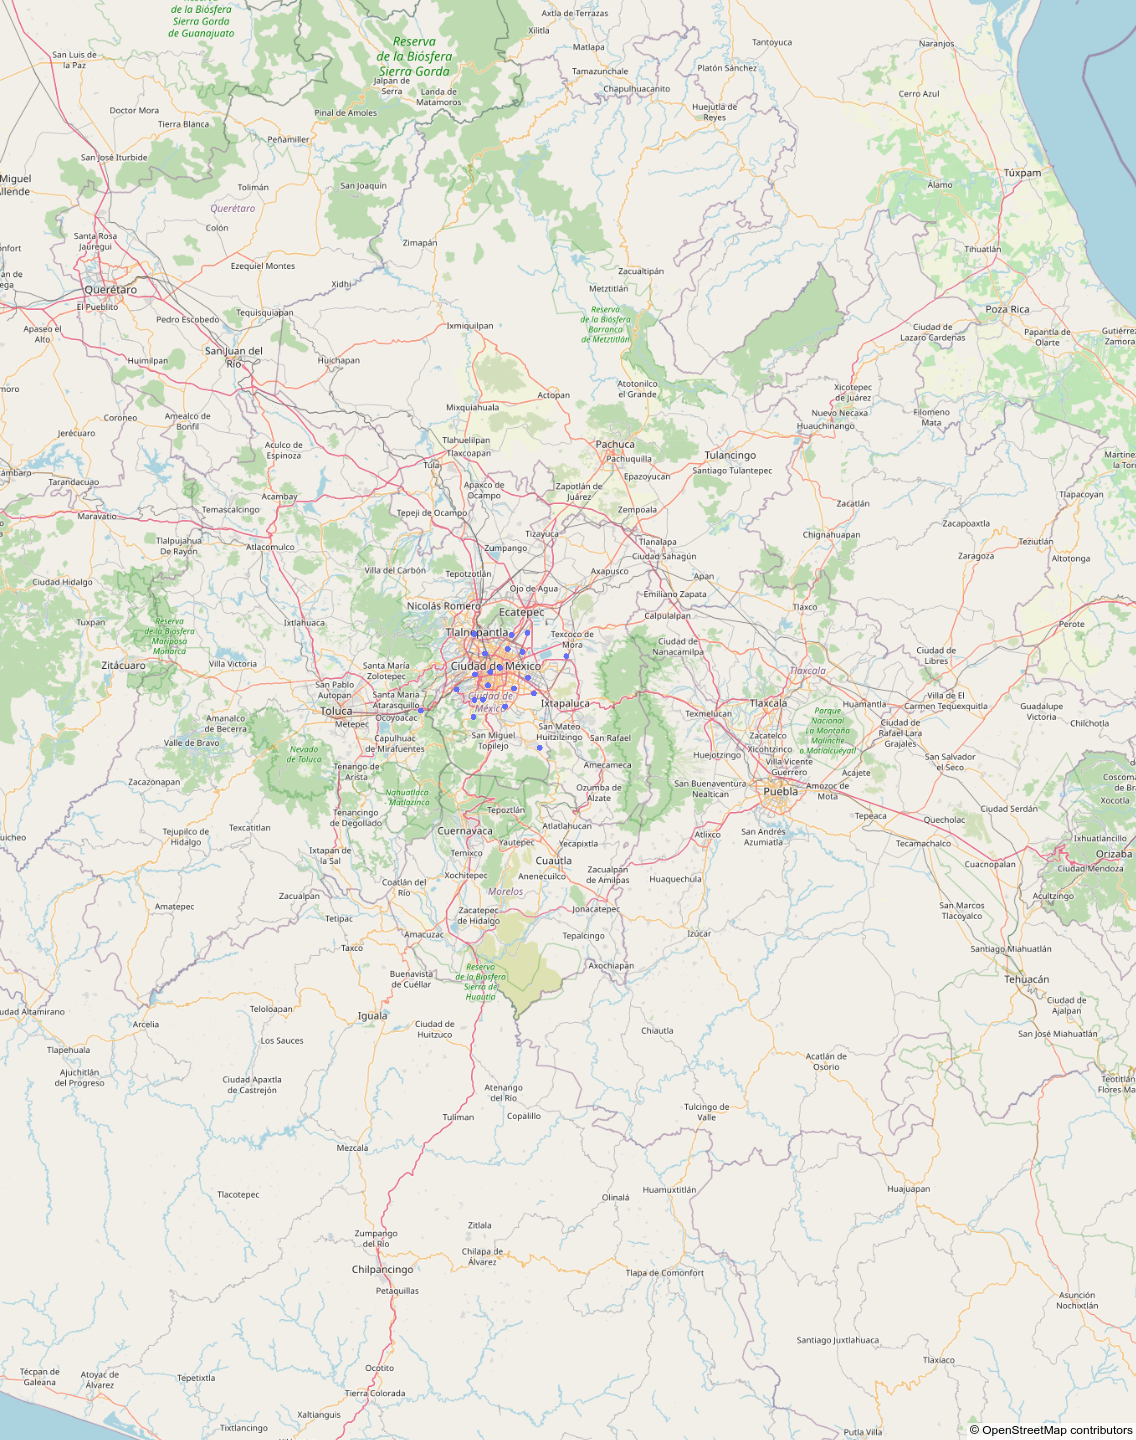

In [75]:
fig = px.scatter_mapbox(pm25, lat="lat", lon="lon",hover_name="id_station_id", zoom=8, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [26]:
uniq = pm25.id_station_id.unique()
n = len(pm25.id_station_id)
x = np.float64(pm25["lon"]).min()
y = np.float64(pm25[pm25["lon"]==x]["lat"]).min()
pm25["lon2"]=pm25["lon"]-x
pm25["lat2"]=pm25["lat"]-y
x1 = np.float64(pm25["lon2"]).min()
y1 = np.float64(pm25[pm25["lon2"]==x1]["lat2"]).min()
for i in range(n):
    if pm25.iloc[i,5] != x:
        pm25.iloc[i,8] = (pm25.iloc[i,8]-x1)*111.321
        pm25.iloc[i,9] = (pm25.iloc[i,9]-y1)*110.948
        
pm25.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
original,1087.0,31.580497,14.018296,1.000000,21.000000,29.000000,40.000000,85.000000
UTC_hour_id,1087.0,14.424103,4.604575,7.000000,10.000000,14.000000,18.000000,22.000000
lon,1087.0,-99.137299,0.089641,-99.380520,-99.202660,-99.152207,-99.073880,-98.902853
lat,1087.0,19.398004,0.089174,19.176900,19.326111,19.404050,19.468404,19.532968
lon2,1087.0,0.243221,0.089641,0.000000,0.177860,0.228313,0.306640,0.477667
lat2,1087.0,11.804069,9.926967,-12.809485,3.800833,12.477080,19.641032,26.828361
NOriginal,1087.0,5.415066,108.575947,-349.794281,-57.770605,0.255848,75.557574,367.673302


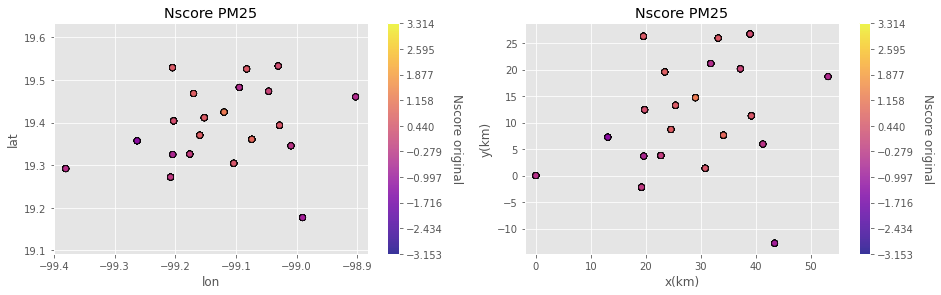

In [77]:
plt.subplot(121)
cmap = plt.cm.plasma
xmaxx = np.float64(pm25["lon"]).max()
ymaxx = np.float64(pm25["lat"]).max()
GSLIB.locmap_st(pm25,'lon','lat','NOriginal',x-0.02,xmaxx+0.02,y-0.2,ymaxx+0.1,np.float64(pm25["NOriginal"]).min(),np.float64(pm25["NOriginal"]).max(),'Nscore PM25','lon','lat','Nscore original',cmap)

plt.subplot(122)
xmaxx = np.float64(pm25["lon2"]).max()
ymaxx = np.float64(pm25["lat2"]).max()
GSLIB.locmap_st(pm25,'lon2','lat2','NOriginal',x1-2,xmaxx+2,np.float64(pm25["lat2"]).min()-2,ymaxx+2,np.float64(pm25["NOriginal"]).min(),np.float64(pm25["NOriginal"]).max(),'Nscore PM25','x(km)','y(km)','Nscore original',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2)
plt.show()

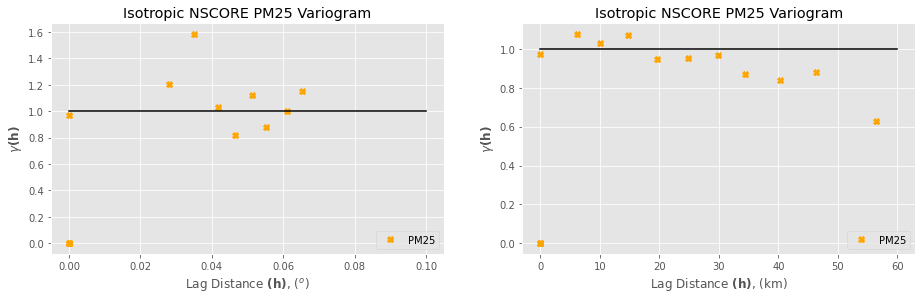

In [78]:
tmin = -9999.; tmax = 9999.; 
dismean = distance_stations(pm25).mean().mean()
plt.subplot(121)
lag_dist = dismean*1e-5; lag_tol = dismean*1e-5/2; nlag = 14; bandh = 9999.9; azi = 0; atol = 90.0; isill = 1
lag, por_sand_gamma, por_sand_npair = geostats.gamv(pm25,"lon","lat","NOriginal",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)

plt.plot(lag,por_sand_gamma,'X',color = 'orange',label = 'PM25')
plt.plot([0,0.1],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, ($^o$)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Isotropic NSCORE PM25 Variogram')

plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(122)
lag_dist = dismean*1e-2; lag_tol = dismean*1e-2/2
lag, por_sand_gamma, por_sand_npair = geostats.gamv(pm25,"lon2","lat2","NOriginal",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)

plt.plot(lag,por_sand_gamma,'X',color = 'orange',label = 'PM25')
plt.plot([0,60],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (km)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Isotropic NSCORE PM25 Variogram')

plt.legend(loc='lower right')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2)
plt.show()

---

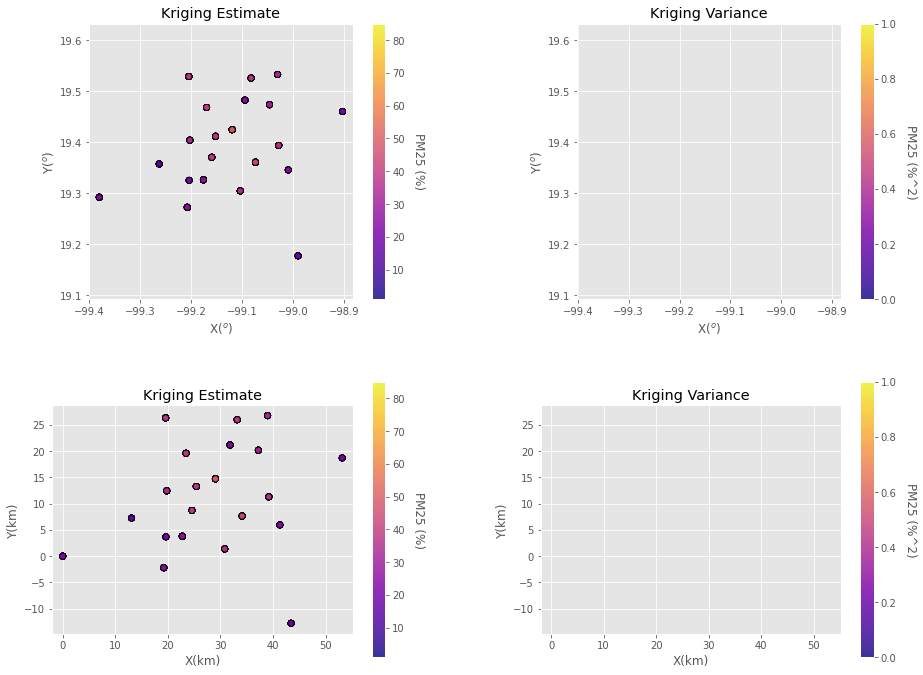

In [80]:
xmin=x-0.02; xmax=np.float64(pm25["lon"]).max()+0.02
ymin=y-0.2; ymax=np.float64(pm25["lat"]).max()+0.1
xsiz = 10; ysiz = 10 
xmn = 5; ymn = 5 
skmean_por = np.float64(pm25["lat"]).mean()# simple kriging mean (used if simple kriging is selected below)
ktype = 0                                  # kriging type, 0 - simple, 1 - ordinary
radius = 0.00557                              # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
nx = 0; ny = 0
ndmin = 0; ndmax = 1000                      # minimum and maximum data for an estimate
#tmin = 1.0                                 # minimum property value
por_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100) # variogram

por_kmap, por_vmap = geostats.kb2d(pm25,'lon','lat','original',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por,por_vario)

plt.subplot(221)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,np.float64(pm25["original"]).min(),np.float64(pm25["original"]).max(),
                pm25,'lon','lat','original','Kriging Estimate','X($^o$)','Y($^o$)','PM25 (%)',cmap)

plt.subplot(222)
GSLIB.pixelplt_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X($^o$)','Y($^o$)','PM25 (%^2)',cmap)

xmin=x1-2.; xmax=np.float64(pm25["lon2"]).max()+2
ymin=np.float64(pm25["lat2"]).min()-2; ymax=np.float64(pm25["lat2"]).max()+2
radius = 50.0                             # search radius for neighbouring data
por_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100) # variogram

por_kmap, por_vmap = geostats.kb2d(pm25,'lon2','lat2','original',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por,por_vario)

plt.subplot(223)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,np.float64(pm25["original"]).min(),np.float64(pm25["original"]).max(),
                pm25,'lon2','lat2','original','Kriging Estimate','X(km)','Y(km)','PM25 (%)',cmap)

plt.subplot(224)
GSLIB.pixelplt_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(km)','Y(km)','PM25 (%^2)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()

/home/jorge/.pyenv/versions/3.8.1/lib/python3.8/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


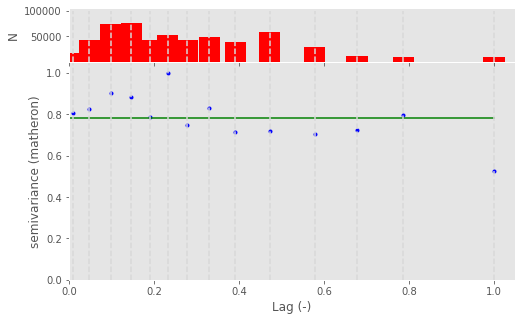

In [7]:
import skgstat as skg

V = skg.Variogram(np.array(pm25.lon,pm25.lat), pm25.original,normalize=True, n_lags=14, maxlag=30 , bin_func = 'kmeans' , verbose = True ,use_nugget = True)
V.plot();

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'spherical' Variogram Model
Partial Sill: -188.64658931504897
Full Sill: 2.7341684472048655e-11
Range: 0.4172698843221701
Nugget: 188.6465893150763 



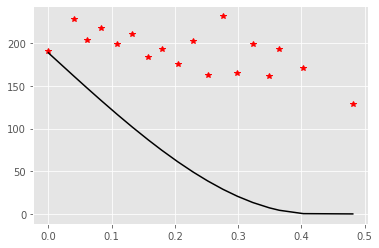

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Predicted_Value:     [31.18075552 47.63845396 47.32385077 ... 18.08154784 49.06988645
 26.96873984]
Sigma²:    [ 977.5596478   639.73182891  300.5925385  ... 1309.58811718  948.94459462
 1683.67477832]


In [29]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt
OK = OrdinaryKriging(
    pm25.lon,
    pm25.lat,
    pm25.original,
    variogram_model="spherical",
    variogram_parameters = {'sill' : V.describe()["sill"] , 'nugget' : V.describe()["nugget"], 'range' :V.describe()["effective_range"] , 'n_lags':14 },
    verbose=True,
    enable_plotting=True,
    coordinates_type="geographic",
    nlags=20,
)

z1, ss1 = OK.execute("points", pm25.lon, pm25.lat)
print("Predicted_Value:    ", np.array(z1))
print("Sigma²:   ", np.array(ss1))

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'linear' Variogram Model
Slope: 1.8788883689800494e-11
Nugget: 11780.817069381497 



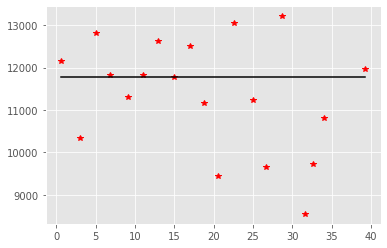

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Predicted_Value:     [5.41506579 5.41506579 5.41506579 ... 5.41506579 5.41506579 5.41506579]
Sigma²:    [11791.65498758 11791.65498758 11791.65498758 ... 11791.65498758
 11791.65498758 11791.65498758]


In [27]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt
OK = OrdinaryKriging(
    pm25.lon2,
    pm25.lat2,
    pm25.NOriginal,
    variogram_model="linear",
    #variogram_parameters = {'sill' : V.describe()["sill"] , 'nugget' : V.describe()["nugget"], 'range' :V.describe()["effective_range"] , 'n_lags':14},
    verbose=True,
    enable_plotting=True,
    coordinates_type="geographic",
    nlags=20,
)

z1, ss1 = OK.execute("points", pm25.lon, pm25.lat)
print("Predicted_Value:    ", np.array(z1))
print("Sigma²:   ", np.array(ss1))

Executing Ordinary Kriging...



/tmp/ipykernel_2700/1722823742.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(a,fraction=0.036, pad=0.04)


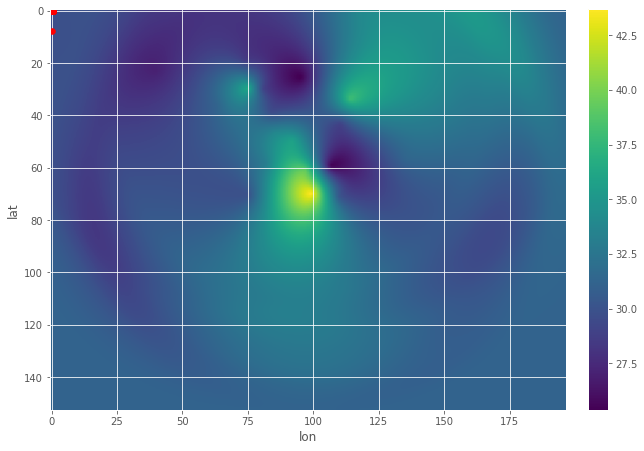

In [21]:
gridx = np.arange(-99.58, -98.6, 0.005)
gridy = np.arange(19.1769, 19.94, 0.005)

z, ss = OK.execute("grid", gridx, gridy)
plt.figure(figsize=(10,10)) 
a=plt.imshow(z)
plt.colorbar(a,fraction=0.036, pad=0.04)
plt.scatter(pm25.lon2, pm25.lat2, c ="red")
plt.xlabel("lon")
plt.ylabel("lat")
plt.show()

Executing Ordinary Kriging...



/tmp/ipykernel_2700/3495553302.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(a,fraction=0.036, pad=0.04)


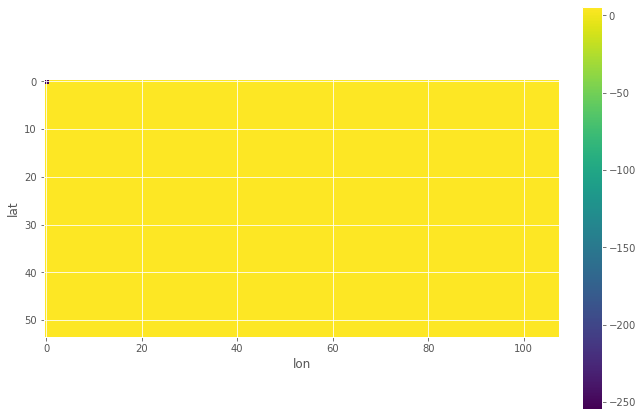

In [28]:
gridx = np.arange(0., 54., 0.5)
gridy = np.arange(0., 27., 0.5)

z, ss = OK.execute("grid", gridx, gridy)
plt.figure(figsize=(10,10)) 
a=plt.imshow(z)
plt.colorbar(a,fraction=0.036, pad=0.04)
plt.xlabel("lon")
plt.ylabel("lat")
plt.show()